# A tiny simulation and integration testing
Test if all functionalities work well together. This is a self-contained test. No outside dataset required.

## Data generation

In [1]:
from functools import reduce
import pickle as pkl

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

## Create a grid
width = 50
height = 8
xs = np.arange(0, width)
ys = np.arange(0, height)
grid_x, grid_y = np.meshgrid(xs, ys)
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()
df = pd.DataFrame(np.array([grid_x, grid_y]).T, 
                  columns=['x', 'y'], 
                  index=reduce(np.char.add, ['cell_', grid_x.astype(str), '_', grid_y.astype(str)]))

## Randomly assign cell types
for y in range(3, 8):
    random_columns = np.random.choice([0, 1, 2], width, p=[0.3, 0.3, 0.4])
    
    df.loc[(random_columns[df['x']] == 0) & (df['y'] == y), 'celltype'] = 'B'
    df.loc[(random_columns[df['x']] == 1) & (df['y'] == y), 'celltype'] = 'C'
    df.loc[(random_columns[df['x']] == 2) & (df['y'] == y), 'celltype'] = 'D'

df.loc[(df['y'] <= 2), 'celltype'] = 'A'

## Generate receptor expression
def go(d, x, y, width, height):
    if d == 'left':
        x = x - 1
    elif d == 'right':
        x = x + 1
    elif d == 'up':
        y = y + 1
    elif d == 'down':
        y = y - 1
    elif d == 'left-up':
        x = x - 1
        y = y + 1
    elif d == 'right-up':
        x = x + 1
        y = y + 1
    elif d == 'left-down':
        x = x - 1
        y = y - 1 
    elif d == 'right-down':
        x = x + 1
        y = y - 1
    
    if x < 0 or y < 0 or x >= width or y >= height:
        return None, None
    else:
        return x, y

df['R+'] = 0
for i in df.index:
    if df.loc[i, 'celltype'] in ['B', 'C']:
        for d in ['left', 'right', 'up', 'down', 'left-up', 'right-up', 'left-down', 'right-down']:
            x, y = go(d, df.loc[i, 'x'], df.loc[i, 'y'], width, height)
            if x is not None and y is not None:
                j = f'cell_{x}_{y}'
                if df.loc[j, 'celltype'] == 'A':
                    if np.random.rand() < 1.:
                        df.loc[i, 'R+'] = 1

meta_expr_split = df.shape[1] # Number of columns for metadata, the rest is "expression"

# Housekeeping genes that are uniform over all cell types
df['H1'] = 50
df['H2'] = 50
df['H3'] = 50
df['H4'] = 50

# Cell identity genes that are over expressed in the corresponding cell type
df['A1'] = 1
df['A2'] = 1
df['B1'] = 1
df['B2'] = 1
df['C1'] = 1
df['C2'] = 1
df['D1'] = 1
df['D2'] = 1

df.loc[df['celltype'] == 'A', 'A1'] = 50 
df.loc[df['celltype'] == 'A', 'A2'] = 50
df.loc[df['celltype'] == 'B', 'B1'] = 50
df.loc[df['celltype'] == 'B', 'B2'] = 50
df.loc[df['celltype'] == 'C', 'C1'] = 50
df.loc[df['celltype'] == 'C', 'C2'] = 50
df.loc[df['celltype'] == 'D', 'D1'] = 50
df.loc[df['celltype'] == 'D', 'D2'] = 50

# LR
df['R'] = 1
df.loc[:, 'R'] = 50 * df['R+']

features = df.columns[meta_expr_split:].tolist()
print(*features)

expr = np.random.poisson(df[features])
expr = pd.DataFrame(expr, index=df.index, columns=features)
expr[['H1', 'H2', 'H3', 'H4']] = 50

H1 H2 H3 H4 A1 A2 B1 B2 C1 C2 D1 D2 R


In [5]:
meta = df.iloc[:, :meta_expr_split]

## Run Steamboat
### Prepare the dataset

In [6]:
import os
import sys
import pickle as pkl
import matplotlib.pyplot as plt

## Add path to the directory containing steamboat.
sys.path.append("../../../") 

import torch
import pandas as pd
import numpy as np
import scipy as sp
import scanpy as sc
import squidpy as sq
import spaceformer as sf
import spaceformer.tools

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [7]:
device = "cuda"

In [9]:
adata = sc.AnnData(expr, obs=meta)
adata.obsm['spatial'] = np.array(meta[['x', 'y']])

adata

adatas = [adata] # You can include multiple datasets here.
adatas = sf.prep_adatas(adatas, log_norm=True)
dataset = sf.make_dataset(adatas)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\anndata\utils.py:292: UserWarning: X converted to numpy array with dtype int64
  warnings.warn(f"{name} converted to numpy array with dtype {arr.dtype}")
100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.16it/s]


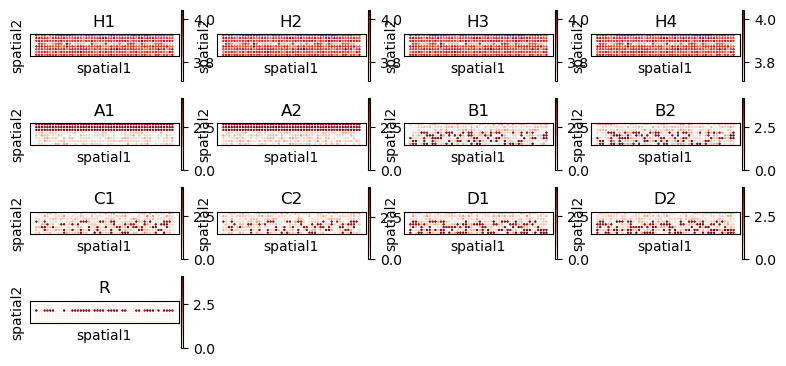

In [10]:
sq.pl.spatial_scatter(adatas[0], color=adatas[0].var_names, shape=None, figsize=(2, 1), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


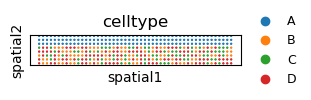

In [11]:
sq.pl.spatial_scatter(adatas[0], color='celltype', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

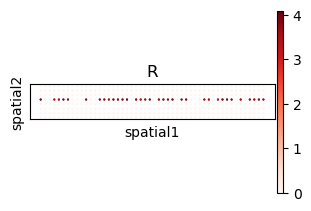

In [12]:
sq.pl.spatial_scatter(adatas[0], color='R', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

### Train and inspect the metagenes

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
[2024-10-22 17:39:44,204::train::INFO] Epoch 1: train_loss 3.95802, reg 0.000000
[2024-10-22 17:39:45,117::train::INFO] Epoch 201: train_loss 0.33273, reg 0.000000
[2024-10-22 17:39:45,804::train::INFO] Epoch 401: train_loss 0.33731, reg 0.000000
[2024-10-22 17:39:46,718::train::INFO] Epoch 601: train_loss 0.29487, reg 0.000000
[2024-10-22 17:39:47,607::train::INFO] Epoch 801: train_loss 0.25162, reg 0.000000
[2024-10-22 17:39:48,516::train::INFO] Epoch 1001: train_loss 0.26546, reg 0.000000
[2024-10-22 17:39:49,404::train::INFO] Epoch 1201: train_loss 0.25208, reg 0.000000
[2024-10-22 17:39:50,256::train::INFO] Epoch 1401: train_loss 0.28805, reg 0.000000
[2024-10-22 17:39:51,225::train::INFO] Epoch 1601: train_loss 0.23574, reg 0.000000
[2024-10-22 17:39:51,761::train::INF

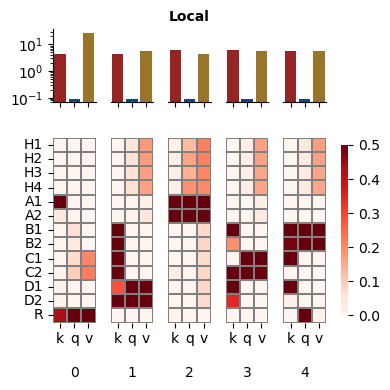

In [13]:
sf.set_random_seed(5)
model = sf.SpaceFormer(adata.var_names.tolist(), d_ego=0, d_local=5, d_global=0)
model = model.to(device)
model.fit(dataset, masking_rate=0.25, masking_method='full', similarity_penalty=0., max_epoch=10000, 
                      opt=torch.optim.Adam, opt_args=dict(lr=0.1), stop_eps=1e-5, report_per=200, stop_tol=1000)
model.fit(dataset, masking_rate=0.25, masking_method='feature', similarity_penalty=0., max_epoch=5000, 
                      opt=torch.optim.Adam, opt_args=dict(lr=0.001), stop_eps=1e-5, report_per=50, stop_tol=200)

sf.tools.plot_transforms(model, figsize=(4, 4), vmin=0.0, vmax=.5, top=0)

### Annotate the adata(s) with the scores

In [14]:
sf.tools.annotate_adatas([adata], dataset, model, get_recon=False)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.79it/s]


### Clustering

In [15]:
spaceformer.tools.neighbors(adata)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib

In [16]:
spaceformer.tools.leiden(adata, resolution=0.1)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


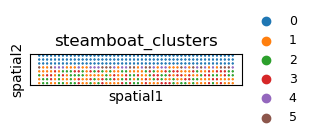

In [17]:
sq.pl.spatial_scatter(adata, color='steamboat_clusters', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)

### Segmentation

In [20]:
spaceformer.tools.segment(adata, resolution=0.5)

C:\Users\lshh\miniconda3\envs\py311_torch211_cuda121\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


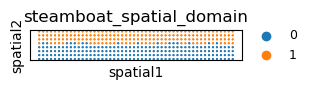

In [23]:
sq.pl.spatial_scatter(adata, color='steamboat_spatial_domain', shape=None, figsize=(3, 2), size=1., 
                      legend_fontsize=9, cmap='Reds', ncols=4)